<a href="https://colab.research.google.com/github/wendikardian/exercise_machine_learning/blob/main/TrafficSignImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wendikardian","key":"8c1011670f54dc1307d99bbedbf7767b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [7]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

 99% 4.14G/4.16G [00:43<00:00, 126MB/s]
100% 4.16G/4.16G [00:43<00:00, 102MB/s]


In [8]:
!mkdir data
!unzip traffic-signs-preprocessed.zip -d data
!ls data

Archive:  traffic-signs-preprocessed.zip
  inflating: data/data0.pickle       
  inflating: data/data1.pickle       
  inflating: data/data2.pickle       
  inflating: data/data3.pickle       
  inflating: data/data4.pickle       
  inflating: data/data5.pickle       
  inflating: data/data6.pickle       
  inflating: data/data7.pickle       
  inflating: data/data8.pickle       
  inflating: data/datasets_preparing.py  
  inflating: data/label_names.csv    
  inflating: data/labels.pickle      
  inflating: data/mean_image_gray.pickle  
  inflating: data/mean_image_rgb.pickle  
  inflating: data/std_gray.pickle    
  inflating: data/std_rgb.pickle     
  inflating: data/test.pickle        
  inflating: data/train.pickle       
  inflating: data/valid.pickle       
data0.pickle  data4.pickle  data8.pickle	   mean_image_gray.pickle  test.pickle
data1.pickle  data5.pickle  datasets_preparing.py  mean_image_rgb.pickle   train.pickle
data2.pickle  data6.pickle  label_names.csv	   std_gray.

In [9]:
## Load the data
training_file = "data/train.pickle"
testing_file = "data/test.pickle"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [11]:
sign_name_df = pd.read_csv('data/label_names.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [12]:
X, y = train['features'], train['labels']

data = np.array(X)
labels = np.array(y)

print(data.shape, labels.shape)


X_test, y_test = test['features'], test['labels']
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


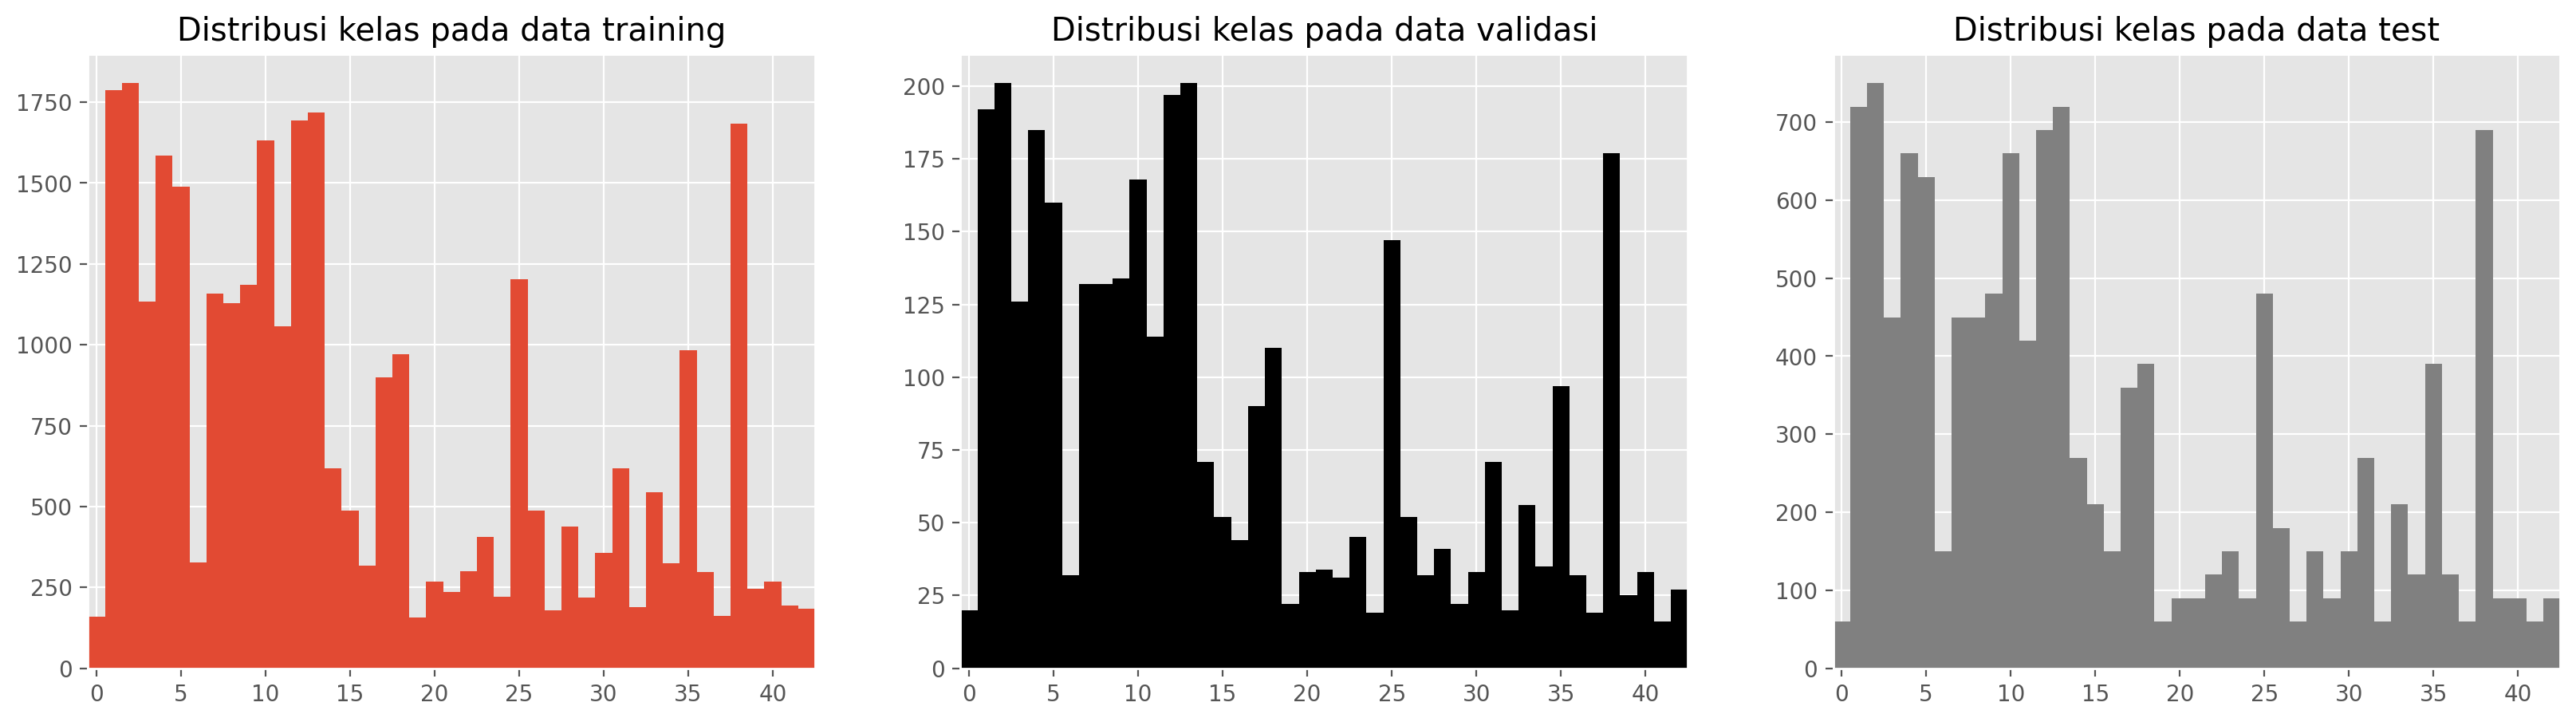

In [14]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title = None, ax = None, **kwargs):
  if not ax :
    fig = plt.figure()
    ax = fig.add_subplot(111)

  ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked = True, **kwargs)
  ax.set_xlim(-0.5, n_labels-0.5)
  if 'label' in kwargs : ax.legen()
  if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 92s 93ms/step - loss: 1.6096 - accuracy: 0.5761 - val_loss: 0.3576 - val_accuracy: 0.9115
Epoch 2/25
979/979 [==============================] - 86s 88ms/step - loss: 0.5443 - accuracy: 0.8377 - val_loss: 0.1919 - val_accuracy: 0.9509
Epoch 3/25
979/979 [==============================] - 103s 105ms/step - loss: 0.3755 - accuracy: 0.8897 - val_loss: 0.1338 - val_accuracy: 0.9606
Epoch 4/25
979/979 [==============================] - 91s 93ms/step - loss: 0.3192 - accuracy: 0.9057 - val_loss: 0.0858 - val_accuracy: 0.9756
Epoch 5/25
979/979 [==============================] - 83s 85ms/step - loss: 0.2820 - accuracy: 0.9197 - val_loss: 0.0696 - val_accuracy: 0.9813
Epoch 6/25
979/979 [==============================] - 84s 86ms/step - loss: 0.2448 - accuracy: 0.9303 - val_loss: 0.0632 - val_accuracy: 0.9865
Epoch 7/25
979/979 [==============================] - 83s 85ms/step - loss: 0.2637 - accuracy: 0.9288 - val_loss: 0.2840 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


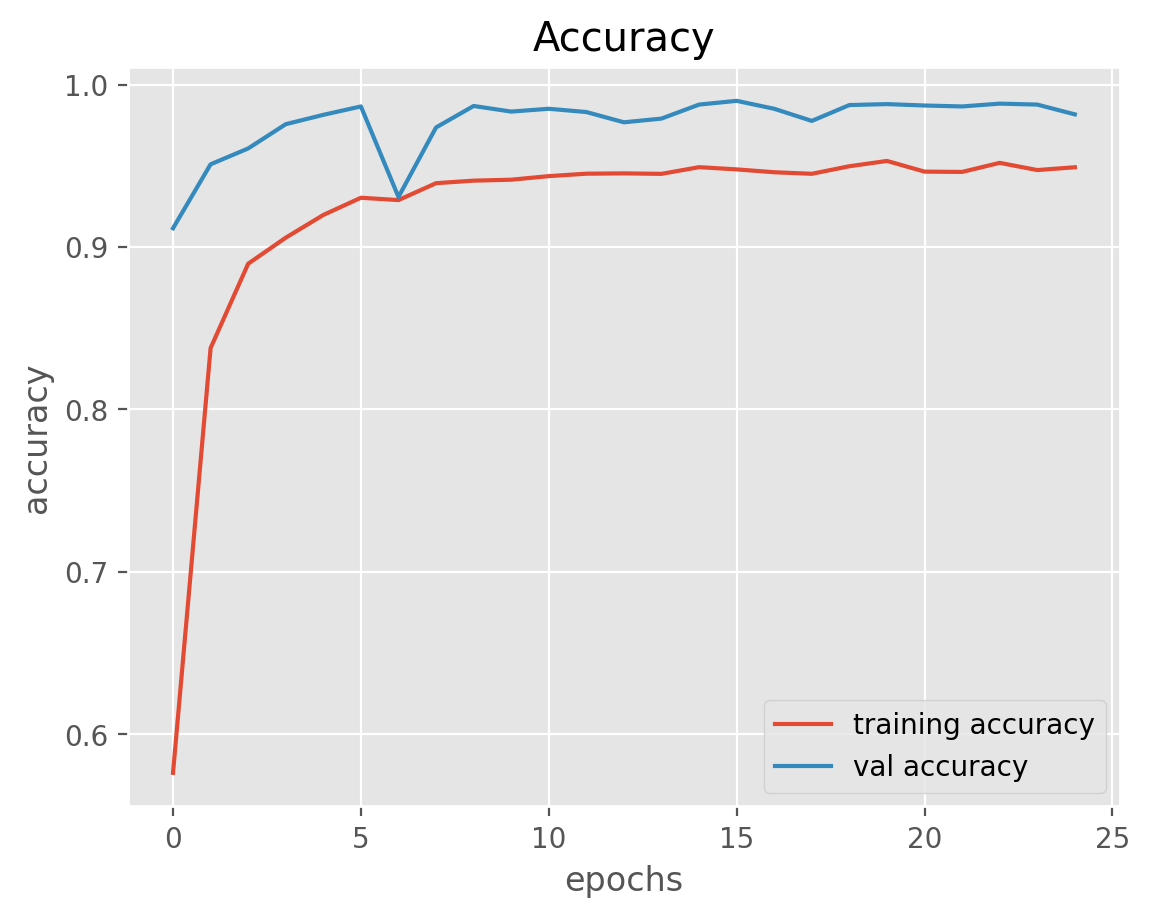

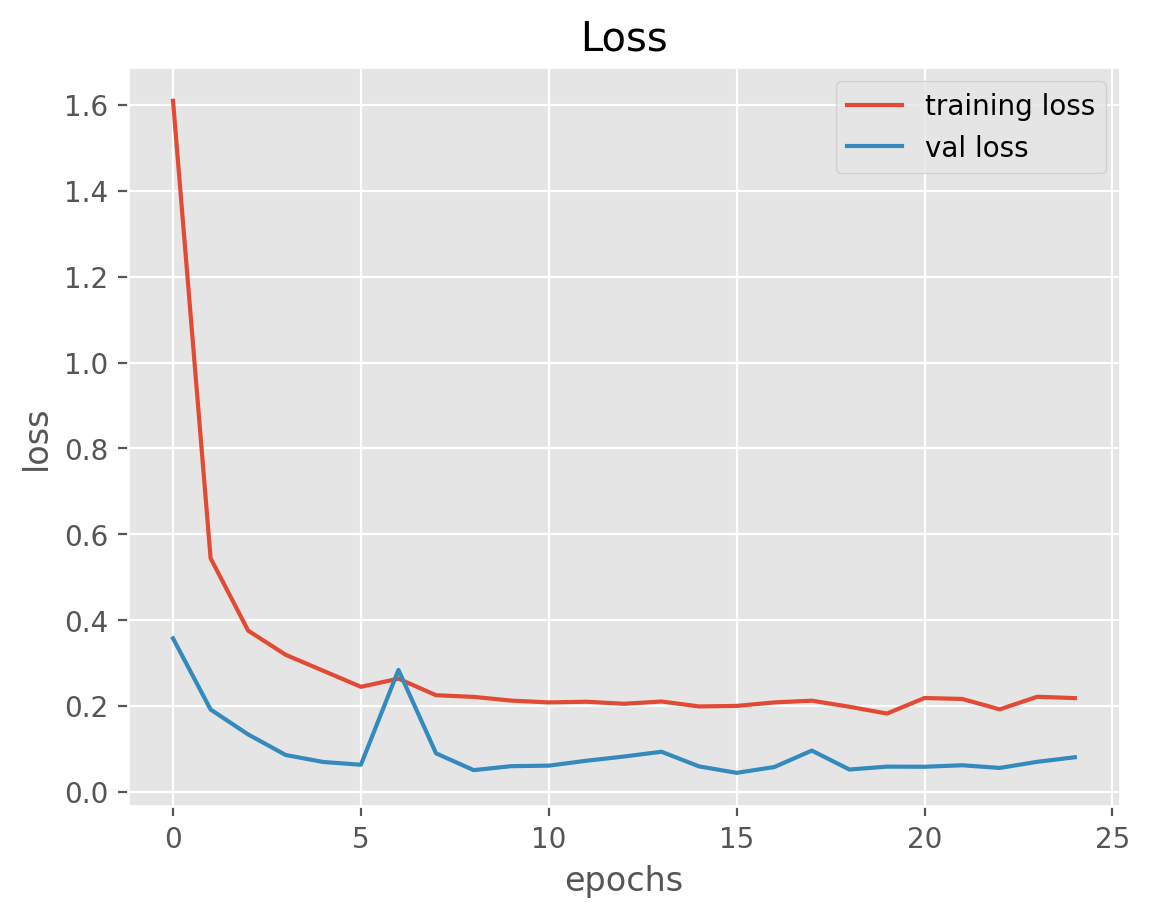

In [22]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis = -1)
accuracy_score(y_test, pred)

395/395 [==============================] - 8s 21ms/step


0.9446555819477435

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.94      0.98      0.96       720
           2       0.95      0.96      0.96       750
           3       0.95      0.91      0.93       450
           4       0.98      0.94      0.96       660
           5       0.87      0.95      0.91       630
           6       0.95      0.81      0.87       150
           7       0.93      0.96      0.94       450
           8       0.96      0.95      0.96       450
           9       0.94      0.99      0.96       480
          10       0.98      0.99      0.99       660
          11       0.95      0.86      0.90       420
          12       0.96      0.99      0.97       690
          13       0.99      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       0.98      0.96      0.97       210
          16       0.99      0.98      0.98       150
          17       0.99    